In [ ]:
import pandas as pd
import kagglehub
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from lightgbm import LGBMClassifier
import shap
%pip install catboost
from catboost import CatBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
import joblib
%pip install dask[dataframe]
import dask.dataframe as dd

# Download the dataset using kagglehub
path = kagglehub.dataset_download("ritwikb3/heart-disease-cleveland")
print("Path to dataset files:", path)

# Load the dataset (assuming it's a CSV file)
cleveland_df = pd.read_csv(f'{path}/Heart_disease_cleveland_new.csv')

# Check the first few rows to understand the structure
print(cleveland_df.head())
print(cleveland_df.columns)


Path to dataset files: /root/.cache/kagglehub/datasets/ritwikb3/heart-disease-cleveland/versions/1
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   0       145   233    1        2      150      0      2.3      2   
1   67    1   3       160   286    0        2      108      1      1.5      1   
2   67    1   3       120   229    0        2      129      1      2.6      1   
3   37    1   2       130   250    0        0      187      0      3.5      2   
4   41    0   1       130   204    0        2      172      0      1.4      0   

   ca  thal  target  
0   0     2       0  
1   3     1       1  
2   2     3       1  
3   0     1       0  
4   0     1       0  
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


In [17]:
# Checking for missing values (though the dataset is mentioned to have no missing values)
cleveland_df.isnull().sum()

# Handle categorical columns by encoding them to numbers
cleveland_df['sex'] = cleveland_df['sex'].map({1: 'Male', 0: 'Female'})
cleveland_df['cp'] = cleveland_df['cp'].map({0: 'typical angina', 1: 'atypical angina', 2: 'non-anginal pain', 3: 'asymptomatic'})
cleveland_df['fbs'] = cleveland_df['fbs'].map({0: 'False', 1: 'True'})
cleveland_df['restecg'] = cleveland_df['restecg'].map({0: 'Normal', 1: 'ST-T wave abnormality', 2: 'left ventricular hypertrophy'})
cleveland_df['exang'] = cleveland_df['exang'].map({0: 'No', 1: 'Yes'})
cleveland_df['slope'] = cleveland_df['slope'].map({0: 'up', 1: 'flat', 2: 'down'})
cleveland_df['thal'] = cleveland_df['thal'].map({1: 'normal', 2: 'fixed defect', 3: 'reversible defect'})

# Map the disease types into a new column 'disease_type'
def map_disease_type(row):
    if row['cp'] == 'typical angina':
        return 'Stable Angina (Typical Angina)'
    elif row['cp'] == 'atypical angina':
        return 'Unstable Angina (Atypical Angina)'
    elif row['cp'] == 'non-anginal pain':
        return 'Non-Anginal Pain'
    elif row['cp'] == 'asymptomatic':
        return 'Asymptomatic Heart Disease'
    elif row['restecg'] == 'left ventricular hypertrophy':
        return 'Left Ventricular Hypertrophy'
    elif row['thal'] == 'reversible defect':
        return 'Myocardial Infarction (Heart Attack)'
    elif row['chol'] > 240:  # Example threshold for high cholesterol
        return 'Coronary Artery Disease (CAD)'
    elif row['trestbps'] > 140:  # Example threshold for high blood pressure
        return 'Hypertensive Heart Disease'
    else:
        return 'Unknown Disease Type'

cleveland_df['disease_type'] = cleveland_df.apply(map_disease_type, axis=1)

# Handle categorical columns by encoding them to numbers using get_dummies
cleveland_df = pd.get_dummies(cleveland_df, drop_first=True)

# Replace whitespace in feature names with underscores
cleveland_df.columns = cleveland_df.columns.str.replace(' ', '_')

# Check the updated columns (after applying pd.get_dummies)
print(cleveland_df.columns)

# Now, after pd.get_dummies(), we should not have 'disease_type' column directly
# Let's use 'disease_type' related columns for multi-output classification
# Separate the feature matrix and target matrix
X_cleveland = cleveland_df.drop(['disease_type_Non-Anginal_Pain', 'disease_type_Stable_Angina_(Typical_Angina)', 'disease_type_Unstable_Angina_(Atypical_Angina)'], axis=1)
y_cleveland = cleveland_df[['disease_type_Non-Anginal_Pain', 'disease_type_Stable_Angina_(Typical_Angina)', 'disease_type_Unstable_Angina_(Atypical_Angina)']]  # Adjust as needed for multi-output classification

# Feature Engineering: Polynomial Features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_cleveland)

# Scaling the features (numerical columns)
scaler = StandardScaler()
numerical_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
X_cleveland[numerical_columns] = scaler.fit_transform(X_cleveland[numerical_columns])


Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca', 'target',
       'sex_Male', 'cp_atypical_angina', 'cp_non-anginal_pain',
       'cp_typical_angina', 'fbs_True', 'restecg_ST-T_wave_abnormality',
       'restecg_left_ventricular_hypertrophy', 'exang_Yes', 'slope_flat',
       'slope_up', 'thal_normal', 'thal_reversible_defect',
       'disease_type_Non-Anginal_Pain',
       'disease_type_Stable_Angina_(Typical_Angina)',
       'disease_type_Unstable_Angina_(Atypical_Angina)'],
      dtype='object')


Logistic Regression on Cleveland Dataset:
Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        65
        True       1.00      1.00      1.00        26

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91

SVM on Cleveland Dataset:
Accuracy: 0.967032967032967
              precision    recall  f1-score   support

       False       0.96      1.00      0.98        65
        True       1.00      0.88      0.94        26

    accuracy                           0.97        91
   macro avg       0.98      0.94      0.96        91
weighted avg       0.97      0.97      0.97        91

KNN on Cleveland Dataset:
Accuracy: 0.8791208791208791
              precision    recall  f1-score   support

       False       0.86      0.98      0.92        65
        True       0.94      0.62      0.74        26

    accuracy     

<Figure size 1000x800 with 0 Axes>

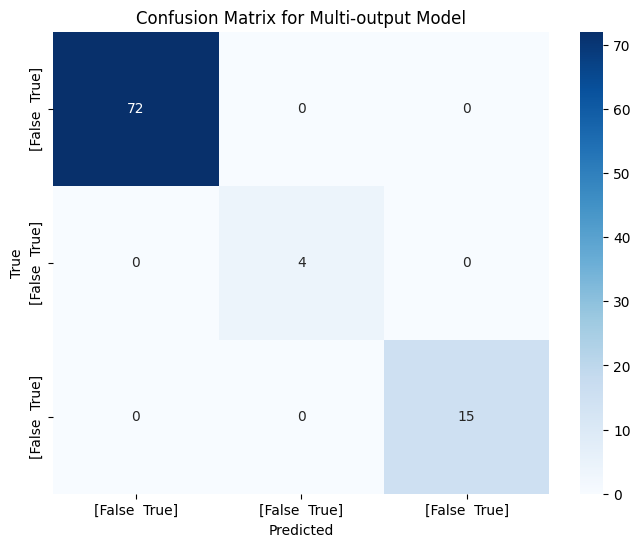

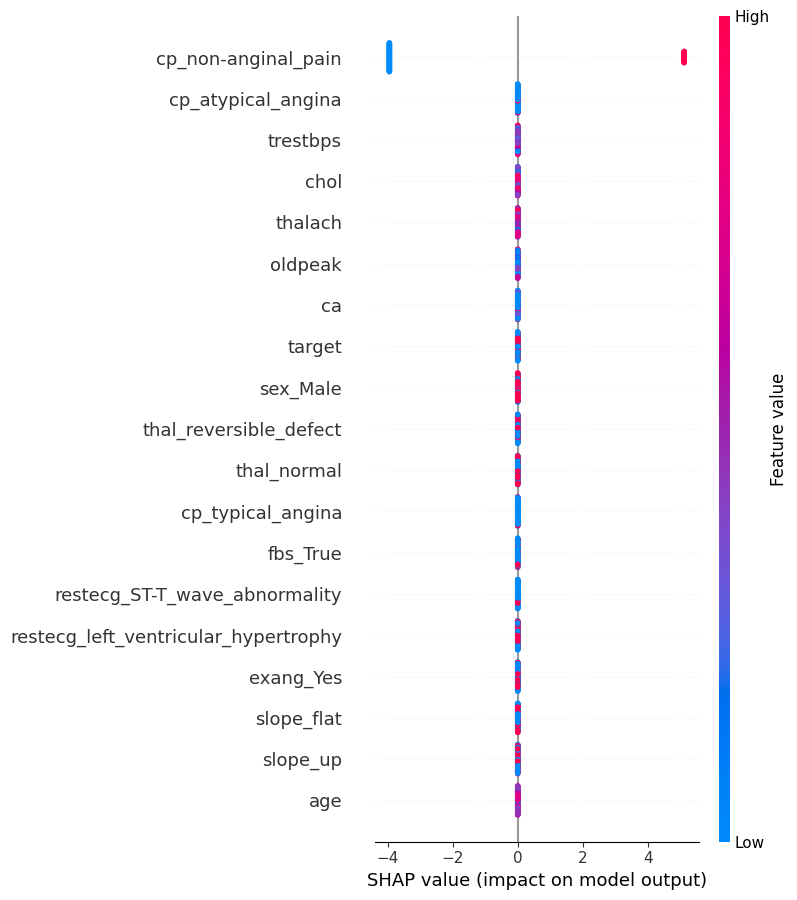

/usr/local/lib/python3.11/dist-packages/shap/plots/_force_matplotlib.py:101: RuntimeWarning: divide by zero encountered in scalar divide
  feature_contribution = np.abs(float(feature[0]) - pre_val) / np.abs(total_effect)


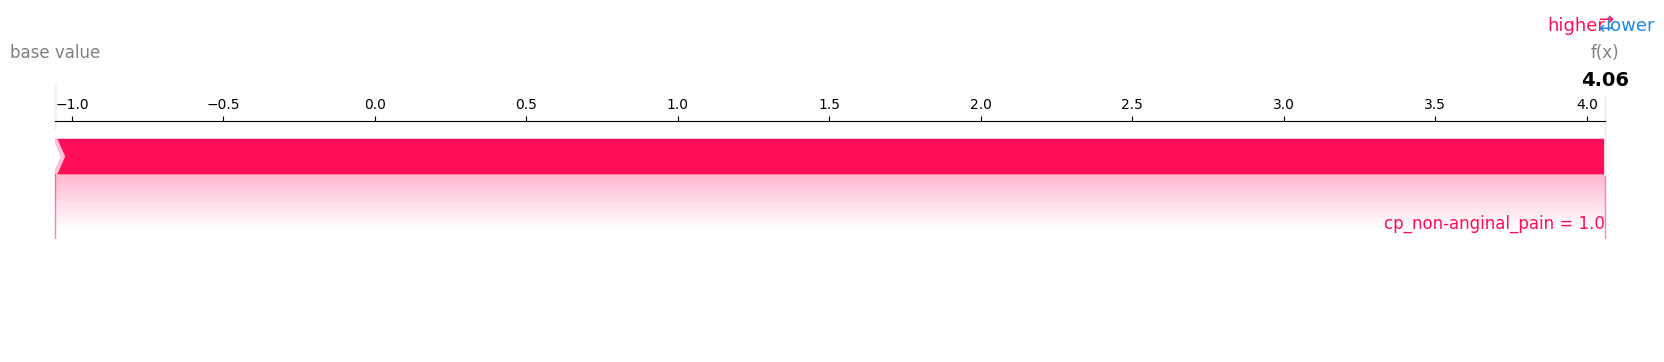

In [18]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Split the dataset into train and test sets
X_train_cleveland, X_test_cleveland, y_train_cleveland, y_test_cleveland = train_test_split(X_cleveland, y_cleveland, test_size=0.3, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(silent=True),
    "Naive Bayes": GaussianNB()
}

# Train and evaluate models on Cleveland dataset
plt.figure(figsize=(10, 8))

# Loop through all models
for model_name, model in models.items():
    if model_name != "Random Forest":  # Use MultiOutputClassifier for Random Forest
        try:
            # Train each model on the first column of y_train_cleveland (change based on your needs)
            model.fit(X_train_cleveland, y_train_cleveland.iloc[:, 0])  # Fit on the first column of the target for now

            # Make predictions
            y_pred_cleveland = model.predict(X_test_cleveland)

            # Print results for each model
            print(f"{model_name} on Cleveland Dataset:")
            print("Accuracy:", accuracy_score(y_test_cleveland.iloc[:, 0], y_pred_cleveland))  # Accuracy on the first target column
            print(classification_report(y_test_cleveland.iloc[:, 0], y_pred_cleveland))

        except Exception as e:
            print(f"Skipping {model_name} due to error: {e}")

# Multi-output classifier (Random Forest in this case)
multi_output_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42))

# Train and evaluate the multi-output model
multi_output_model.fit(X_train_cleveland, y_train_cleveland)

# Predict multiple disease types
y_pred_multi = multi_output_model.predict(X_test_cleveland)

# Classification report for multi-output model
print("Multi-output Model Classification Report:")
print(classification_report(y_test_cleveland, y_pred_multi))

# Calculate accuracy for multi-output classification
# Accuracy score for each output column
accuracy_scores = [accuracy_score(y_test_cleveland.iloc[:, i], y_pred_multi[:, i]) for i in range(y_test_cleveland.shape[1])]

# Print accuracy scores for each disease type
for i, score in enumerate(accuracy_scores):
    print(f"Accuracy for {y_test_cleveland.columns[i]}: {score:.4f}")

# Visualize confusion matrix for multi-output model
conf_matrix = confusion_matrix(y_test_cleveland.values.argmax(axis=1), y_pred_multi.argmax(axis=1))  # Adjust to handle multi-output
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=multi_output_model.classes_, yticklabels=multi_output_model.classes_)
plt.title('Confusion Matrix for Multi-output Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# SHAP for Tree-Based Models (e.g., XGBoost)
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_cleveland, y_train_cleveland.iloc[:, 0])  # Train on the original features, not transformed ones

# Create the SHAP explainer
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_cleveland)

# Summary plot for feature importance
shap.summary_plot(shap_values, X_test_cleveland)

# Initialize JavaScript visualization
shap.initjs()

# Create force plot for the first instance
# Get the base value (expected value)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[0]

# Get SHAP values for the first instance
if isinstance(shap_values, list):
    instance_shap_values = shap_values[0]
else:
    instance_shap_values = shap_values

# Create force plot for the first instance
shap.force_plot(expected_value,
                instance_shap_values[0,:],
                X_test_cleveland.iloc[0,:],
                feature_names=list(X_test_cleveland.columns),
                matplotlib=True)
plt.show()


Skipping XGBoost due to error: 'super' object has no attribute '__sklearn_tags__'
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 15
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 16, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062500 -> initscore=-2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves

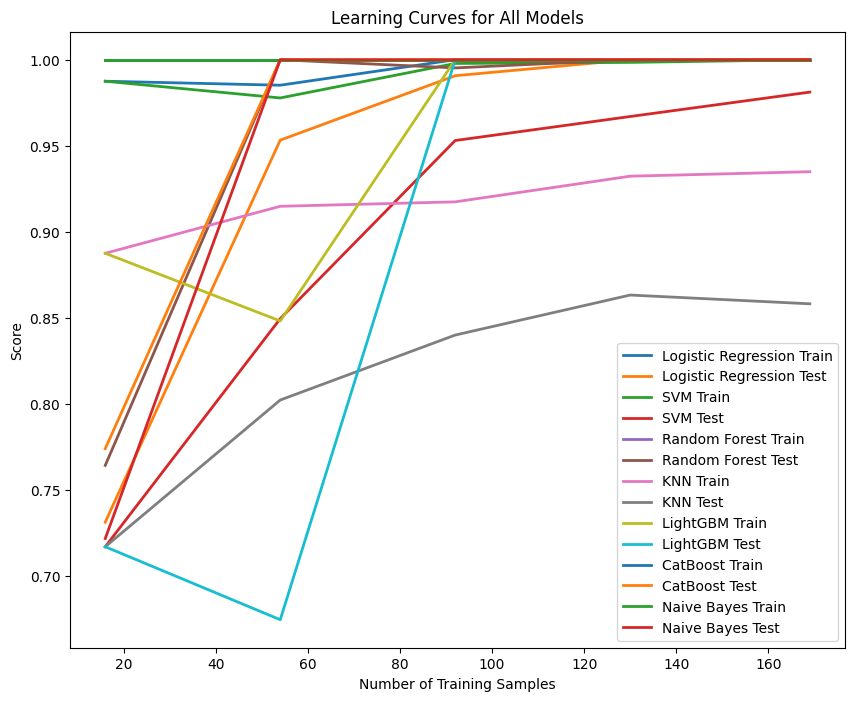

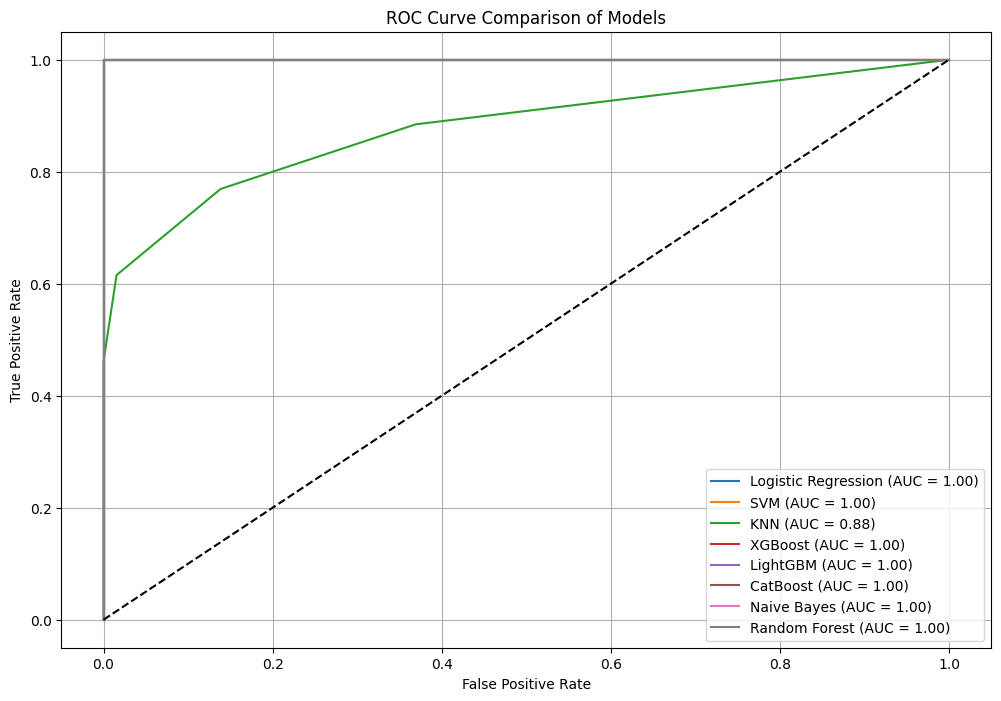

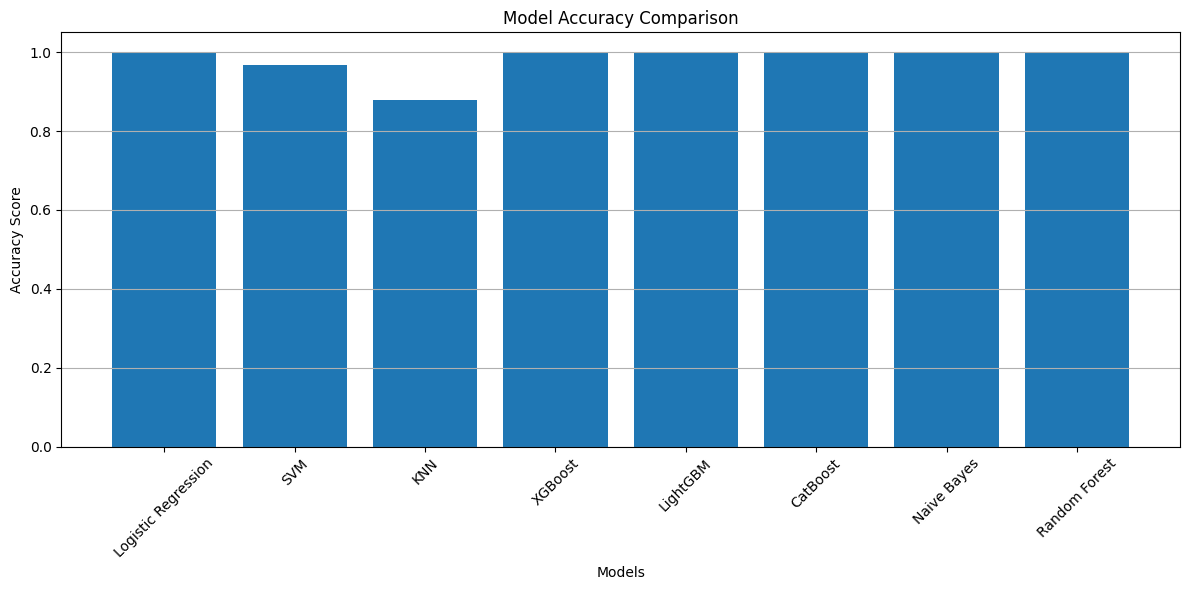

In [19]:
# Learning curve plot
plt.figure(figsize=(10, 8))

# Loop through all models to plot their learning curves
for model_name, model in models.items():
    try:
        # Only plot learning curves for models that work with sklearn's learning_curve
        train_sizes, train_scores, test_scores = learning_curve(model, X_train_cleveland, y_train_cleveland.iloc[:, 0], cv=5, n_jobs=1)  # Avoid parallelism for simplicity

        # Plotting the learning curve
        plt.plot(train_sizes, train_scores.mean(axis=1), label=f'{model_name} Train', lw=2)
        plt.plot(train_sizes, test_scores.mean(axis=1), label=f'{model_name} Test', lw=2)

    except Exception as e:
        print(f"Skipping {model_name} due to error: {e}")

plt.title('Learning Curves for All Models')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend()
plt.show()

# ROC Curve Comparison
plt.figure(figsize=(12, 8))
for model_name, model in models.items():
    if model_name != "Random Forest":  # Skip Random Forest as it's handled separately
        try:
            # Get probability predictions
            y_prob = model.predict_proba(X_test_cleveland)[:, 1]

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test_cleveland.iloc[:, 0], y_prob)
            roc_auc = roc_auc_score(y_test_cleveland.iloc[:, 0], y_prob)

            # Plot ROC curve
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

        except Exception as e:
            print(f"Skipping ROC curve for {model_name} due to error: {e}")

# Add Random Forest ROC curve (using the first estimator of multi_output_model)
rf_prob = multi_output_model.estimators_[0].predict_proba(X_test_cleveland)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test_cleveland.iloc[:, 0], rf_prob)
roc_auc_rf = roc_auc_score(y_test_cleveland.iloc[:, 0], rf_prob)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Model Accuracy Comparison
plt.figure(figsize=(12, 6))
model_accuracies = {}

# Calculate accuracies for all models except Random Forest
for model_name, model in models.items():
    if model_name != "Random Forest":
        try:
            y_pred = model.predict(X_test_cleveland)
            accuracy = accuracy_score(y_test_cleveland.iloc[:, 0], y_pred)
            model_accuracies[model_name] = accuracy
        except Exception as e:
            print(f"Skipping accuracy calculation for {model_name} due to error: {e}")

# Add Random Forest accuracy (using the first target)
rf_accuracy = accuracy_score(y_test_cleveland.iloc[:, 0], y_pred_multi[:, 0])
model_accuracies["Random Forest"] = rf_accuracy

# Create bar plot
plt.bar(range(len(model_accuracies)), list(model_accuracies.values()))
plt.xticks(range(len(model_accuracies)), list(model_accuracies.keys()), rotation=45)
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy Score')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


In [20]:
# Save the models
for model_name, model in models.items():
    joblib.dump(model, f'{model_name}_model.pkl')

# Save the multi-output random forest model
joblib.dump(multi_output_model, 'multi_output_model.pkl')

# If you use the same preprocessing steps (scaler and poly), save them as well
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(poly, 'poly.pkl')

from sklearn.preprocessing import OneHotEncoder
# Create encoder and train it on your training data
encoder = OneHotEncoder(drop='first', sparse_output=False)  # or any other configuration you used, handle_unknown='ignore' if needed for new categories
# Assuming you want to encode categorical features before scaling
categorical_features = X_cleveland.select_dtypes(include=['object', 'category']).columns # Selects categorical features for encoding
encoder.fit(X_train_cleveland[categorical_features]) # Fit using training data

# Save the encoder
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [ ]:
import joblib
poly = joblib.load('poly.pkl')
print("Training features:", poly.get_feature_names_out())

Training features: ['age' 'trestbps' 'chol' 'thalach' 'oldpeak' 'ca' 'target' 'sex_Male'
 'cp_atypical_angina' 'cp_non-anginal_pain' 'cp_typical_angina' 'fbs_True'
 'restecg_ST-T_wave_abnormality' 'restecg_left_ventricular_hypertrophy'
 'exang_Yes' 'slope_flat' 'slope_up' 'thal_normal'
 'thal_reversible_defect' 'age trestbps' 'age chol' 'age thalach'
 'age oldpeak' 'age ca' 'age target' 'age sex_Male'
 'age cp_atypical_angina' 'age cp_non-anginal_pain'
 'age cp_typical_angina' 'age fbs_True'
 'age restecg_ST-T_wave_abnormality'
 'age restecg_left_ventricular_hypertrophy' 'age exang_Yes'
 'age slope_flat' 'age slope_up' 'age thal_normal'
 'age thal_reversible_defect' 'trestbps chol' 'trestbps thalach'
 'trestbps oldpeak' 'trestbps ca' 'trestbps target' 'trestbps sex_Male'
 'trestbps cp_atypical_angina' 'trestbps cp_non-anginal_pain'
 'trestbps cp_typical_angina' 'trestbps fbs_True'
 'trestbps restecg_ST-T_wave_abnormality'
 'trestbps restecg_left_ventricular_hypertrophy' 'trestbps exang